In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import matplotlib.style as style
style.use('seaborn-whitegrid')

import os
import pprint
# import googlemaps
# import time
import pickle
from random import randint
from collections import defaultdict, Counter

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, MiniBatchKMeans

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TreebankWordTokenizer, wordpunct_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.util import ngrams
from nltk.corpus import stopwords

from textblob import TextBlob

import string



In [3]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [51]:
# Set pandas options
pd.set_option('max_rows', 10)
# pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

**Add stopwords to NLTK**

In [33]:
# Add to stopwords
stopwords = nltk.corpus.stopwords.words('english')
new_stop_words = ['portland', 'oregon', 'Portland', 'Oregon', 'house', 'home', 'apartment']
stopwords.extend(new_stop_words)

**Load the relevant data file**

In [58]:
# df = pd.read_csv('data/portland_reviews.csv', index_col=None)
# df = pd.read_csv('data/cleaned_reviews.csv', index_col='Unnamed: 0')
mini_df = pd.read_csv('data/mini_reviews_df.csv', index_col='Unnamed: 0')
# df = pd.read_csv('data/listing_descriptions.csv', index_col=0)
# df = pd.read_csv('data/cleaned_df.csv', index_col=None)
df = pd.read_csv('data/final_full_df.csv', index_col='Unnamed: 0')

/Users/brenner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,couldnt possibl better experi trip would give ...,0.275000,0.650000,158,couldnt possibly better experience trip would ...,3,couldnt possibly had a better experience with ...,"['couldnt', 'possibly', 'had', 'a', 'better', ...",29,4.241379,[]
1,7893,17461247,2014-08-12,13284006,Jessica,Jesse's place was really wonderful! The apartm...,jess place realli wonder apart locat block awa...,0.275463,0.601852,670,jesses place really wonderful apartment locate...,10,jesses place was really wonderful the apartmen...,"['jesses', 'place', 'was', 'really', 'wonderfu...",119,4.436975,"[('place', 2), ('really', 2), ('apartment', 2)]"


In [265]:
summaries[0]

"Located on Williams bike corridor, some of Portland's best restaurants, bars and coffee shops are within a 5min drive and downtown is only 10min away.  Also features a wrap around patio with a covered awning to stay dry during the rainy season."

In [77]:
df.head(2)

,id,host_id,summary,space,description,neighborhood_overview,notes,host_about
0,7893,21489,"Located on Williams bike corridor, some of Por...",This NE Portland 2 bedroom home is located jus...,"Located on Williams bike corridor, some of Por...",NaN,NaN,"I love to cook, sail and play the mandolin ver..."
1,12899,49682,Settle in to a space of your own. You'll have ...,We live in a neighborhood of beautiful gardens...,Settle in to a space of your own. You'll have ...,We're within walking distance of a grocery and...,We welcome musicians and even have a guitar fo...,"We enjoy cooking, singing, hiking, bicycles, t..."


In [81]:
df.columns

Index(['id', 'host_id', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'host_about'],
      dtype='object')

In [92]:
# Fill NaNs with empty strings
for col in ['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'host_about']:
    df[col].fillna('', inplace=True)


# Make sure there are not any null values remaining
df.head(2)

,id,host_id,summary,space,description,neighborhood_overview,notes,host_about
0,7893,21489,"Located on Williams bike corridor, some of Por...",This NE Portland 2 bedroom home is located jus...,"Located on Williams bike corridor, some of Por...",,,"I love to cook, sail and play the mandolin ver..."
1,12899,49682,Settle in to a space of your own. You'll have ...,We live in a neighborhood of beautiful gardens...,Settle in to a space of your own. You'll have ...,We're within walking distance of a grocery and...,We welcome musicians and even have a guitar fo...,"We enjoy cooking, singing, hiking, bicycles, t..."


In [244]:
descriptions = df['description']
about_host_text = df['host_about']
summaries = df['summary']
type(summaries)

pandas.core.series.Series

#### Remove punctuation, make lowercase, etc.

In [163]:
# Make lower case
summaries = summaries.apply(lambda x: x.lower())



In [164]:
summaries = pd.DataFrame(summaries)

In [165]:
# Remove punctuation
summaries['nopunc'] = summaries['summary'].str.replace('[^\w\s]','')

In [166]:
summaries

,summary,nopunc
0,"located on williams bike corridor, some of por...",located on williams bike corridor some of port...
1,settle in to a space of your own. you'll have ...,settle in to a space of your own youll have 2 ...
2,"newly remodeled 2 bedroom (3 queen beds), 2 fu...",newly remodeled 2 bedroom 3 queen beds 2 full ...
3,"if you are an urban farming pioneer, enthusias...",if you are an urban farming pioneer enthusiast...
4,"if you are an urban farming pioneer, enthusias...",if you are an urban farming pioneer enthusiast...
...,...,...
5400,moderate sized room with north garden and east...,moderate sized room with north garden and east...
5401,modern portland home with mid-century charm! t...,modern portland home with midcentury charm thi...
5402,1 bed 1 bath apartment living in ultra posh do...,1 bed 1 bath apartment living in ultra posh do...
5403,this is a cozy basement studio nestled on the ...,this is a cozy basement studio nestled on the ...


In [ ]:
# Tokenize by sentence
summaries['sent_tokenize'] = summaries['nopunc'].apply(lambda x: sent_tokenize(x))

In [153]:
# Tokenize by word
tokenizer = TreebankWordTokenizer()
summaries['word_tok'] = summaries['sent_tok'].apply(lambda x: [tokenizer.tokenize(y) for y in x])

In [ ]:
def get_count(item):
    return item[1]

for word, count in sorted(gatsby.word_counts.items(), key=get_count, reverse=True):
    print("%15s %i" % (word, count))

#### Feature Engineering - Polarity, subjectivity, length, sentence length, most frequent words

In [407]:
def get_sentiment(text):
    return TextBlob(text).sentiment[0]

def get_subjectivity(text):
    return TextBlob(text).sentiment[1]

In [810]:
df['polarity'] = df['comments'].apply(get_sentiment)
df['subjectivity'] = df['comments'].apply(get_subjectivity)

# Create column with character length of review
df['review_length'] = df['comments'].apply(len)

# Create column with the number of sentences per review
df['num_sentences'] = df['comments'].apply(lambda x: len(sent_tokenize(x)))

df['comment_words_only'] = df['comments'].apply(lambda x: re.sub('[^A-Za-z ]+', '', x.lower()))

# Create column with all individual words
df['individual_words'] = df['comment_words_only'].apply(lambda x: x.split(' '))

# Create column for word count
df['word_count'] = df['individual_words'].apply(len)

# Create column for the average length of words in each review
def get_avg_word_len(text):
    lengths = []
    for word in text:
        lengths.append(len(word))
    return sum(lengths) / len(lengths)

df['average_word_length'] = df['individual_words'].apply(get_avg_word_len)

In [824]:
# Get most frequent words
def get_most_frequent_words(text):
    words = Counter(text.split()).most_common(3)
    return [word for word in words if word[1] > 1]

df['most_frequent_words'] = df['cleaned_comments'].apply(get_most_frequent_words)

In [822]:
get_most_frequent_words(df['cleaned_comments'][16])

[('couldnt', 2)]

In [621]:
# Groupby listing ID, concat all reviews into one long string for getting most frequent words
pd.DataFrame(mini_df.groupby('listing_id')['reviews_cleaned_str'].agg(lambda x: ' '.join(x)))

,reviews_cleaned_str
listing_id,
12899,realli enjoy stay dave beauti home great neigh...
26203,excel first experi airbnb exactli expect descr...
37676,awesom place paul extrem friendli help great t...
39938,sarah host simpli incred home gorgeou street b...
41601,marbl room like time capsul mani littl thing d...
...,...
27631229,realli great easili access area check super ea...
28167575,realli nice time patricia place
28197448,great place stay nice part portland would defi...


In [623]:
Counter(comm['reviews_cleaned_str'][12899].split()).most_common(10)

[('great', 7),
 ('stay', 6),
 ('host', 6),
 ('like', 4),
 ('portland', 4),
 ('david', 4),
 ('time', 4),
 ('space', 4),
 ('definit', 4),
 ('home', 3)]

In [428]:
def process_text_no_stems(text):
    text = re.sub('[^A-Za-z ]+', '', text)
    text = text.lower().split()
    text = [word for word in text if ((len(word) > 3) and (word not in stop))]
    text = ' '.join(text)
    return text

In [429]:
process_text_no_stems(df['comments'][0])

'couldnt possibly better experience trip would give stars could thanks everything jesse condo fantastic'

In [430]:
df['cleaned_comments'] = df['comments'].apply(process_text_no_stems)

**Save DF to CSV**

In [829]:
# df.to_csv('data/cleaned_reviews.csv')

In [509]:
tokenizer = TreebankWordTokenizer()

def get_text_chunks(text):
    tags = pos_tag(word_tokenize(text))
    return [x for x in tags if x[1]=='NNP']

In [38]:
get_text_chunks(mini_df['comments'][0])

NameError: name 'get_text_chunks' is not defined

In [ ]:
pos_tag(df['comments'][1].split())

##### Create a mini dataframe of reviews to speed up processing time for testing (commented out and loaded from result)

In [15]:
mini_df = df.sample(n=25000, replace=False, random_state=22)
# mini_df.reset_index(inplace=True)
# mini_df.to_csv('data/mini_reviews_df.csv')
# mini_df = pd.read_csv('data/mini_reviews_df.csv', index_col='Unnamed: 0')

In [16]:
mini_df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words
48257,1677299,98722579,2016-09-01,12555755,Shaun,Ivy was a wonderful host! She welcomed us with...,wonder host welcom surpris basket fuel rest we...,0.308333,0.725,296,wonderful host welcomed surprise basket fueled...,5,ivy was a wonderful host she welcomed us with ...,"['ivy', 'was', 'a', 'wonderful', 'host', 'she'...",60,3.683333,"[('home', 2)]"
242359,15910855,307161783,2018-08-13,153332906,Matthew,"Great place to stay, would go back.",great place stay would back,0.400000,0.375,35,great place stay would back,1,great place to stay would go back,"['great', 'place', 'to', 'stay', 'would', 'go'...",7,3.857143,[]


In [493]:
mini_df.groupby('listing_id')['polarity'].mean()

listing_id
12899       0.435046
26203       0.257143
37676       0.438628
39938       0.467092
41601       0.439063
              ...   
27631229    0.628333
28167575    0.750000
28197448    0.466667
28226590    0.089167
28480171    0.347917
Name: polarity, Length: 2261, dtype: float64

#### Train-Test-Split

In [13]:
df.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'reviews_cleaned_str', 'polarity', 'subjectivity', 'review_length',
       'cleaned_comments', 'num_sentences', 'comment_words_only',
       'individual_words', 'word_count', 'average_word_length',
       'most_frequent_words'],
      dtype='object')

In [137]:
X = df[['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'reviews_cleaned_str', 'polarity', 'subjectivity', 'review_length',
       'cleaned_comments', 'num_sentences', 'comment_words_only',
       'individual_words', 'word_count', 'average_word_length',
       'most_frequent_words']]

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,couldnt possibl better experi trip would give ...,0.275,0.65,158,couldnt possibly better experience trip would ...,3,couldnt possibly had a better experience with ...,"['couldnt', 'possibly', 'had', 'a', 'better', ...",29,4.241379,[]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [138]:
test_df = df.sample(n=100000, replace=False, random_state=22)

#### Count Vectorizer, LDA

In [221]:
tf_vectorizer = CountVectorizer(max_df=0.5,
                                min_df=2,
                                lowercase=True,
                                strip_accents='unicode',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                stop_words='english', ngram_range=(1,2)
                               )
dtm_tf = tf_vectorizer.fit_transform(summaries)

In [207]:
dtm_tf.shape

(5405, 4706)

In [208]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0)
lda_tf.fit(dtm_tf)

# # for TFIDF DTM
# lda_tfidf = LatentDirichletAllocation(n_topics=20, random_state=0)
# lda_tfidf.fit(dtm_tfidf)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [62]:
tf.shape

(5405, 5058)

In [66]:
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
doc_vectors = vectorizer.fit_transform(summaries)

In [70]:
doc_vectors

<5405x89207 sparse matrix of type '<class 'numpy.float64'>'
	with 359635 stored elements in Compressed Sparse Row format>

In [201]:
lda_tf = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=10.0, batch_size=128,
                                random_state=49, evaluate_every=-1)
lda_tf.fit(tf)

In [464]:
vocab = tf_vectorizer.get_feature_names()

for topic in range(10):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda.components_,1)[topic,:10]:
        print(vocab[j])
    print()

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

In [260]:
def run_lda_with_defaults(corpus, num_topics):
    tf_vectorizer = CountVectorizer(lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)
    
    lda_tf = LatentDirichletAllocation(n_components=num_topics, random_state=0, n_jobs=-1)
    lda_tf.fit(dtm_tf)
    
    return pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [379]:
def run_lda(corpus, num_topics):
    tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)
    
    lda_tf = LatentDirichletAllocation(n_components=num_topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
    lda_tf.fit(dtm_tf)
    
    return pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [255]:
def run_lda(corpus, num_topics):
    tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english',
                                    ngram_range=(1,3))
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)
    
    lda_tf = LatentDirichletAllocation(n_components=num_topics, random_state=0, learning_method='online', n_jobs=-1)
    lda_tf.fit(dtm_tf)
    
    return pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [222]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10, ngram_range=(1,2))
dtm_tf = tf_vectorizer.fit_transform(summaries)
print(dtm_tf.shape)

(5405, 3766)


In [223]:
lda_tf = LatentDirichletAllocation(n_topics=10, random_state=0, learning_method='online', batch_size=1028)
lda_tf.fit(dtm_tf)

/Users/brenner/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=1028, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [259]:
run_lda_with_defaults(descriptions, 10)

/Users/brenner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.069935  0.017552       1        1  24.356309
1      0.039434  0.069310       2        1  17.605827
0     -0.084185  0.154308       3        1  17.480405
6     -0.067826  0.070179       4        1  11.803181
9      0.036567  0.047240       5        1   9.663327
3      0.060626 -0.063598       6        1   6.518400
7      0.093458 -0.041467       7        1   4.518141
4     -0.000710  0.001390       8        1   3.071818
2     -0.252597 -0.130306       9        1   2.701773
8      0.105296 -0.124607      10        1   2.280819, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
9958   Default  5656.000000         room  5656.000000  30.0000  30.0000
486    Default  2556.000000    apartment  2556.000000  29.0000  29.0000
8338   Default  1774.000000         park  1774.000000  28.0000  28.0000
8870   Default  6697.000000     portland  6697.000000  27.0000  27.0000
1041   Default  3488.000000          bed  3488.000000  26.0000  26.0000
...        ...          ...          ...          ...      ...      ...
977    Topic10    53.709214     bathroom  2863.712166  -0.1957  -5.2560
5075   Topic10    51.609911        great  2288.945358  -0.0115  -5.2958
2384   Topic10    45.134626  comfortable  1644.301980   0.1852  -5.4299
10914  Topic10    42.105588     spacious  1079.955990   0.5361  -5.4994
7722   Topic10    42.159485         need  1299.012425   0.3527  -5.4981

[854 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
23         1  0.046196  absolutely
23         2  0.027717  absolutely
23         4  0.083152  absolutely
23         6  0.674455  absolutely
23         8  0.129347  absolutely
...      ...       ...         ...
13157      8  0.898537        yurt
13164      2  0.061413         zen
13164      5  0.153533         zen
13164      7  0.706251         zen
13164      8  0.092120         zen

[2766 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 1, 7, 10, 4, 8, 5, 3, 9])

#### Reviews Data

In [5]:
df = pd.read_csv('data/portland_reviews.csv')

In [6]:
def replace_nans(column):
    return column.fillna('', inplace=True)

In [368]:
porter = nltk.stem.porter.PorterStemmer()
stop = stopwords.words('english')

# Remove punctuation and numerical characters
# Make lowercase and split on whitespace
# Stem words

def process_text(text):
    text = re.sub('[^A-Za-z ]+', '', text)
    text = text.lower().split()
    text = [word for word in text if ((len(word) > 3) and (word not in stop))]
    text = [porter.stem(word) for word in text]
    return text

In [360]:
reviews = df['comments']
reviews.fillna('', inplace=True)

In [369]:
reviews_cleaned = reviews.apply(process_text)

In [381]:
df['reviews_cleaned'] = reviews_cleaned

In [370]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,"[couldnt, possibl, better, experi, with, thi, ..."
1,7893,17461247,2014-08-12,13284006,Jessica,Jesse's place was really wonderful! The apartm...,"[jess, place, realli, wonder, apart, locat, bl..."


In [383]:
df['reviews_cleaned_str'] = df['reviews_cleaned'].str.join(' ')

In [389]:
df.drop('reviews_cleaned', axis=1, inplace=True)

In [416]:
reviews_cleaned

0         [couldnt, possibl, better, experi, trip, would...
1         [jess, place, realli, wonder, apart, locat, bl...
2         [recommend, good, valu, spaciou, airi, upper, ...
3         [day, visit, portland, enorm, enhanc, alison, ...
4         [wonder, time, stay, area, alberta, artsth, be...
                                ...                        
318257    [moda, center, host, doug, quick, commun, rece...
318258               [feel, home, cozi, apart, great, view]
318259    [great, experi, hous, amen, requir, clean, eve...
318260    [thank, host, appreci, good, commun, highli, r...
318261    [elli, place, terrif, everyth, comfort, live, ...
Name: comments, Length: 318262, dtype: object

#### Fit-transform into matrix for further clustering

In [630]:
dtm_tf

<5405x3766 sparse matrix of type '<class 'numpy.int64'>'
	with 209291 stored elements in Compressed Sparse Row format>

In [ ]:
vocab = tf_vectorizer.get_feature_names()

for topic in range(10):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda_tf.components_,1)[topic,:10]:
        print(vocab[j])
    print()

In [646]:
lda.perplexity(tf)

784.8127128854413

In [89]:
X = lda_tf.components_

In [90]:
X.shape

(10, 422)

In [658]:
X = pd.Series(X)

In [661]:
km = KMeans(n_clusters=5)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [663]:
km.inertia_

2537424.621555204

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)

In [674]:
#    tf_vectorizer = CountVectorizer(lowercase=True,
#                                     strip_accents='unicode',
#                                     token_pattern = r'\b[a-zA-Z]{3,}\b',
#                                     stop_words='english')
    
#     dtm_tf = tf_vectorizer.fit_transform(corpus)
    
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0, n_jobs=-1)
lda_tf.fit_transform(dtm_tf)

array([[0.00400066, 0.59732322, 0.00400078, ..., 0.00400052, 0.00400141,
        0.00400078],
       [0.003031  , 0.19566205, 0.00303108, ..., 0.23809163, 0.00303088,
        0.00303104],
       [0.00156277, 0.54239545, 0.30493594, ..., 0.00156283, 0.00156287,
        0.00156284],
       ...,
       [0.00416731, 0.58501459, 0.00416734, ..., 0.0041683 , 0.38164438,
        0.00416804],
       [0.00178639, 0.00178604, 0.00178605, ..., 0.65630595, 0.00178619,
        0.00178613],
       [0.24495315, 0.00454613, 0.00454605, ..., 0.00454608, 0.00454696,
        0.30123185]])

In [684]:
# for topic in range(20):
#     print(f"TOPIC {topic}")
#     for j in np.argsort(-lda.components_,1)[topic,:10]:
#         print(vocab[j])
#     print()

TOPIC 0
place
great
business
travelers
close
couples
good
solo
adventurers
neighborhood

TOPIC 1
tabor
fun
outdoor
covered
backyard
scene
patio
fred
providence
serene

TOPIC 2
district
pearl
score
ceilings
loft
high
heart
steps
stay
bar

TOPIC 3
new
brand
experience
seasons
home
modern
designed
visit
school
guesthouse

TOPIC 4
north
friendly
people
welcome
live
kenton
light
friends
avenue
pets

TOPIC 5
room
private
bed
bedroom
queen
bathroom
kitchen
living
bath
space

TOPIC 6
coffee
fridge
tea
microwave
breakfast
mini
available
access
maker
use

TOPIC 7
alberta
apartment
arts
district
basement
located
house
home
blocks
studio

TOPIC 8
dryer
washer
house
tub
kitchen
unit
hot
enjoy
space
cozy

TOPIC 9
cute
square
sleeping
feet
nook
smoking
transport
backyard
cottage
inside

TOPIC 10
downtown
ohsu
available
waterfront
term
rental
rent
parking
south
near

TOPIC 11
home
stay
perfect
center
just
located
historic
neighborhood
space
away

TOPIC 12
views
forest
city
table
johns
deck
home
river


In [689]:
mini_df['reviews_cleaned_str']

0       wonder host welcom surpris basket fuel rest we...
1                             great place stay would back
2       trip portland made feel right home made trip m...
3       daniel joel place perfect stay week everyth ne...
4       locat quiet neighborhood spot walk distanc any...
                              ...                        
4995    place great locat close light rail didnt need ...
4996    area cute realli get steak whiley place commun...
4997    david gave wonder advic thing trip portland we...
4998    accommod hous felt like home truli comfort sta...
4999    cute effici feel like ikea catalog spread loca...
Name: reviews_cleaned_str, Length: 5000, dtype: object

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.5,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')
    
dtm_tf = tf_vectorizer.fit_transform(mini_df['reviews_cleaned_str'])

In [705]:
tf_vectorizer.get_feature_names()[:10]

['aanrad',
 'aaron',
 'abbi',
 'aber',
 'abil',
 'abl',
 'abod',
 'absenc',
 'absolut',
 'abund']

In [ ]:
lda_tf = LatentDirichletAllocation(n_components=num_topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
lda_tf.fit_transform(dtm_tf)

In [735]:
vec = CountVectorizer()
matrix = vec.fit_transform(mini_df['reviews_cleaned_str'])
pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())

,aankomst,aanrad,aanwezig,aaron,abbi,abe,aber,abil,abl,abnb,...,zipper,zitj,zoe,zona,zone,zonsondergang,zumindest,zumstein,zupan,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
new2.shape

(318262, 10)

In [722]:
km = MiniBatchKMeans(n_clusters=10)
km.fit(matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [62]:
pred = km.fit_transform(new2)

In [724]:
km.inertia_

130296.75856808036

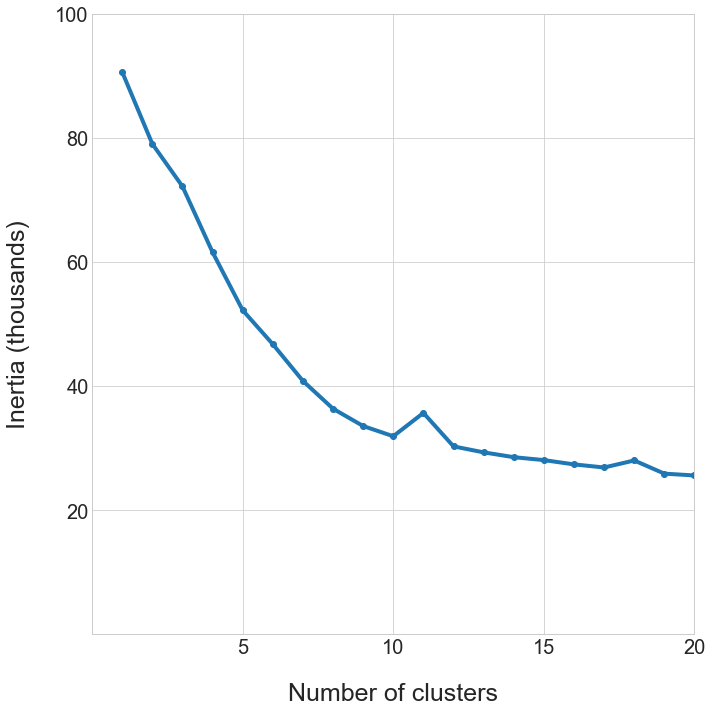

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(list_num_clusters,inertia, linewidth=4)
plt.scatter(list_num_clusters,inertia)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia');

ax.set_yticklabels(['', 20,40,60,80,100])
ax.set_xticks([5,10,15,20])
ax.set_xlim(0,20)
ax.set_ylim(0,100000)

ax.set_ylabel('Inertia (thousands)', labelpad=25, fontsize=25)
ax.set_xlabel('Number of clusters', labelpad=25, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
# ax.grid(False)

plt.tight_layout()
# plt.savefig('plots/inertia.jpg', dpi=300)

In [96]:
km = KMeans(n_clusters=8)
km.fit(new2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [66]:
pred = km.fit_transform(new2)

In [766]:
for i in km.cluster_centers_:
    print(i.max())

0.36101083032490977
2.046511627906977
0.7565217391304347
1.3455637091394264
2.3601609657947686
2.013215859030837


In [54]:
print(km.cluster_centers_)

[[0.03656175 0.03090418 0.03671904 0.02162196 0.37701634 0.35702108
  0.03253487 0.0353447  0.03299583 0.03928026]
 [0.57225711 0.04577798 0.05123828 0.02924079 0.06255202 0.05097674
  0.05529908 0.0404764  0.05269658 0.03948503]
 [0.05758972 0.04942386 0.06579508 0.48265502 0.10219565 0.03278154
  0.0527594  0.04590767 0.05564834 0.05524373]
 [0.0434112  0.04169169 0.05614896 0.30198657 0.03776924 0.32610443
  0.05084162 0.04472034 0.04085622 0.05646974]
 [0.04384407 0.04464916 0.04095461 0.03578244 0.05258147 0.04002919
  0.04400736 0.034339   0.35546648 0.30834621]
 [0.19880631 0.37906881 0.0303596  0.02026201 0.17061952 0.03034215
  0.04447472 0.03947154 0.05232127 0.03427407]
 [0.03572117 0.03788946 0.03384904 0.02293266 0.0324266  0.36336831
  0.04809216 0.03842324 0.35041372 0.03688364]
 [0.04275678 0.04353719 0.02974377 0.02424819 0.0592556  0.03722083
  0.03755473 0.0244401  0.67683543 0.02440738]
 [0.12370959 0.04198521 0.15537539 0.04050249 0.07540136 0.06346414
  0.06945059

In [97]:
df['cluster_pred'] = km.predict(new2)

In [100]:
df.groupby('cluster_pred').describe()

average_word_length                                          \
                           count      mean       std       min       25%   
cluster_pred                                                               
0                        38979.0  4.414957  0.526667  0.133333  4.111111   
1                        42301.0  4.692053  0.667175  0.181818  4.287500   
2                        49177.0  4.400512  0.411870  0.195122  4.145455   
3                        37810.0  4.389457  0.410175  0.231579  4.135135   
4                        39471.0  4.384279  1.351876  0.000000  4.133333   
5                        33071.0  4.534450  0.511007  0.254237  4.206897   
6                        40128.0  4.747692  0.752404  0.544910  4.276596   
7                        37325.0  4.589028  0.468864  0.220339  4.290598   

                                                  id                ...    \
                   50%       75%        max    count          mean  ...     
cluster_pred                                                        ...     
0             4.358621  4.636364  12.000000  38979.0  1.568710e+08  ...     
1             4.595745  4.970588  12.000000  42301.0  1.714256e+08  ...     
2             4.361702  4.605263   9.333333  49177.0  1.665759e+08  ...     
3             4.362069  4.605263   8.666667  37810.0  1.569846e+08  ...     
4             4.434783  4.775510  67.000000  39471.0  1.697895e+08  ...     
5             4.470588  4.806452  11.250000  33071.0  1.742207e+08  ...     
6             4.615385  5.067893  14.500000  40128.0  2.006058e+08  ...     
7             4.541284  4.821429  15.000000  37325.0  1.725886e+08  ...     

             subjectivity      word_count                                   \
                      75%  max      count       mean        std  min   25%   
cluster_pred                                                                 
0                0.722222  1.0    38979.0  57.151210  46.356684  1.0  26.0   
1                0.766667  1.0    42301.0  34.958535  25.496212  1.0  17.0   
2                0.678333  1.0    49177.0  84.010777  64.455248  1.0  41.0   
3                0.720833  1.0    37810.0  65.137159  47.139941  1.0  34.0   
4                0.708821  1.0    39471.0  43.116212  36.554185  1.0  16.0   
5                0.683333  1.0    33071.0  51.497415  38.847092  1.0  24.0   
6                0.777778  1.0    40128.0  25.614509  19.794011  1.0  11.0   
7                0.718500  1.0    37325.0  54.374869  35.886763  1.0  30.0   

                                  
               50%    75%    max  
cluster_pred                      
0             47.0   75.0  514.0  
1             29.0   47.0  410.0  
2             69.0  108.0  561.0  
3             55.0   84.0  519.0  
4             36.0   60.0  485.0  
5             43.0   67.0  511.0  
6             21.0   35.0  313.0  
7             47.0   70.0  500.0  

[8 rows x 72 columns]

In [67]:
def k_mean_distance(data, cx, cy, i_centroid, cluster_labels):
        distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in data[cluster_labels == i_centroid]]
        return distances
clusters=pred
centroids = km.cluster_centers_

distances = []
for i, (cx, cy) in enumerate(centroids):
    mean_distance = k_mean_distance(data2D, cx, cy, i, clusters)
    distances.append(mean_distance)

print(distances)

ValueError: too many values to unpack (expected 2)

for i in range (0, 6):
    print(f'\nCluster #{i}:\n')
    print(mini_df[mini_df['cluster_pred']==i]['comments'][:11].values)

In [755]:
mini_df.columns

Index(['index', 'listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name',
       'comments', 'reviews_cleaned_str', 'polarity', 'subjectivity',
       'review_length', 'cleaned_comments', 'cluster_pred'],
      dtype='object')

In [781]:
mini_df.groupby('cluster_pred').mean()

,index,listing_id,id,reviewer_id,polarity,subjectivity,review_length,num_sentences
cluster_pred,,,,,,,,
0,170988.483755,1.067775e+07,1.834945e+08,6.358497e+07,0.378962,0.626172,179.386282,3.131167
1,139032.558140,8.433975e+06,1.386277e+08,3.843336e+07,0.333045,0.572869,1277.627907,13.662791
2,144363.229565,8.659678e+06,1.487984e+08,4.520289e+07,0.358610,0.605424,540.780870,6.760000
3,168834.026017,1.054570e+07,1.826870e+08,5.842258e+07,0.510836,0.661042,191.773182,3.418279
4,165790.394366,1.037835e+07,1.760991e+08,5.553882e+07,0.389078,0.625418,405.977867,5.563380
5,148415.027900,8.959630e+06,1.535050e+08,4.748164e+07,0.375847,0.621449,387.023495,5.444934


In [780]:
mini_df.groupby('listing_id').mean()

,index,id,reviewer_id,polarity,subjectivity,review_length,cluster_pred,num_sentences
listing_id,,,,,,,,
12899,208.000000,4.172736e+07,8.117452e+06,0.435046,0.644374,351.500000,1.875000,4.250000
26203,575.000000,2.220860e+05,4.503810e+05,0.257143,0.469048,260.000000,0.000000,4.000000
37676,699.000000,6.864086e+06,1.910440e+06,0.438628,0.577965,560.000000,3.000000,8.333333
39938,853.333333,1.154776e+08,2.371007e+07,0.467092,0.590487,395.666667,2.333333,6.333333
41601,1031.500000,1.846395e+05,3.233805e+05,0.439063,0.690972,155.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...
27631229,317741.000000,3.257698e+08,1.917696e+08,0.628333,0.675000,102.000000,3.000000,4.000000
28167575,318115.000000,3.274645e+08,2.164211e+08,0.750000,1.000000,46.000000,0.000000,1.000000
28197448,318125.000000,3.216481e+08,6.662344e+07,0.466667,0.783333,143.000000,5.000000,3.000000


In [779]:
mini_df.describe()

,index,listing_id,id,reviewer_id,polarity,subjectivity,review_length,cluster_pred,num_sentences
count,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,163139.836400,1.010372e+07,1.736710e+08,5.649768e+07,0.415949,0.632605,294.353400,2.225200,4.372600
std,92511.502449,7.267730e+06,9.551488e+07,5.392084e+07,0.187234,0.153816,249.195646,1.794416,2.764507
min,16.000000,1.289900e+04,7.141800e+04,1.000000e+00,-0.750000,0.000000,0.000000,0.000000,0.000000
25%,82410.500000,3.761821e+06,9.029888e+07,1.327119e+07,0.303901,0.556582,132.000000,0.000000,3.000000
50%,165305.000000,8.714815e+06,1.740933e+08,3.680000e+07,0.401220,0.635714,236.500000,3.000000,4.000000
75%,244618.750000,1.605875e+07,2.601940e+08,8.763617e+07,0.516938,0.725000,387.250000,3.000000,6.000000
max,318210.000000,2.848017e+07,3.343601e+08,2.173200e+08,1.000000,1.000000,2886.000000,5.000000,35.000000


In [778]:
mini_df['num_sentences'] = mini_df['comments'].apply(lambda x: len(sent_tokenize(x)))

In [830]:
mini_df['cluster_pred'].value_counts()

0    1662
3    1499
5     681
2     575
4     497
1      86
Name: cluster_pred, dtype: int64

#### New workflow

In [10]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...
1,7893,17461247,2014-08-12,13284006,Jessica,Jesse's place was really wonderful! The apartm...


In [136]:
mini_df.head(2)

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments
0,48257,1677299,98722579,2016-09-01,12555755,Shaun,Ivy was a wonderful host! She welcomed us with...,wonder host welcom surpris basket fuel rest we...,0.308333,0.725,296,wonderful host welcomed surprise basket fueled...
1,242359,15910855,307161783,2018-08-13,153332906,Matthew,"Great place to stay, would go back.",great place stay would back,0.400000,0.375,35,great place stay would back


In [ ]:
mini_df = df.sample(n=5000, replace=False, random_state=22)

In [82]:
def run_new_lda(corpus, topics):
    tf_vectorizer = CountVectorizer(max_df=0.95,
                                    min_df=2,
                                    lowercase=True,
                                    strip_accents='unicode',
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    stop_words='english')

    dtm_tf = tf_vectorizer.fit_transform(corpus)

    vocab = np.array(tf_vectorizer.get_feature_names())
    counts = np.array(dtm_tf.sum(0))[0,:]
    vocab[np.argsort(-counts)[:100]]

    lda_tf = LatentDirichletAllocation(n_components=topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
    lda_tf.fit(dtm_tf) #or fit_transform
    
    return dtm_tf, vocab, counts, lda_tf

In [71]:
lda_tf.perplexity(dtm_tf)

1874.0727072615089

In [97]:
def run_new_lda(corpus, topics):
    tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                lowercase=True,
                                strip_accents='unicode',
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                stop_words='english')
    
    dtm_tf = tf_vectorizer.fit_transform(corpus)

    vocab = np.array(tf_vectorizer.get_feature_names())
    counts = np.array(dtm_tf.sum(0))[0,:]
    vocab[np.argsort(-counts)[:100]]

    lda_tf = LatentDirichletAllocation(n_components=topics,
                                       random_state=0,
                                       learning_method='online',
                                       learning_decay=0.6,
                                       learning_offset=1024,
                                       batch_size=256,
                                       topic_word_prior=.005,
                                       n_jobs=-1)
    lda_tf.fit(dtm_tf) #or fit_transform

In [98]:
run_new_lda(mini_df['cleaned_comments'], 6)

CURRENT

In [17]:
# mini_df['cleaned_comments'].fillna('', inplace=True)
df['cleaned_comments'].fillna('', inplace=True)

In [48]:
tf_vectorizer = CountVectorizer(
                            max_df=0.3,
                            min_df=.01,
                            lowercase=True,
                            strip_accents='unicode',
                            token_pattern = r'\b[a-zA-Z]{3,}\b',
                            stop_words='english',
                            ngram_range=(1,2))

dtm_tf = tf_vectorizer.fit_transform(mini_df['cleaned_comments'])

vocab = np.array(tf_vectorizer.get_feature_names())
counts = np.array(dtm_tf.sum(0))[0,:]
vocab[np.argsort(-counts)[:100]]

lda_tf = LatentDirichletAllocation(n_components=10,
                                   random_state=0,
                                   learning_method='online',
                                   learning_decay=0.6,
                                   learning_offset=1024,
                                   batch_size=256,
                                   topic_word_prior=.05,
                                   n_jobs=-1)
lda_tf.fit_transform(dtm_tf) #or fit_transform

LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.6,
             learning_method='online', learning_offset=1024,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=0.05,
             total_samples=1000000.0, verbose=0)

In [63]:
lda_tf.perplexity(dtm_tf)

295.98955115390305

In [51]:
new = tf_vectorizer.transform(df['cleaned_comments'])

In [55]:
new2 = lda_tf.transform(new)

In [56]:
new2.shape

(318262, 10)

#### Backup with pickle

In [60]:
# with open('backups/tf_vectorized_reviews.pickle', 'wb') as p:
#     pickle.dump(new, p)
    
# with open('backups/lda_transformed_reviews.pickle', 'wb') as p:
# pickle.dump(new2, p)

#### Open pickled files

In [18]:
with open('backups/tf_vectorized_reviews.pickle', 'rb') as p:
    new = pickle.load(p)
    
with open('backups/lda_transformed_reviews.pickle', 'rb') as p:
    new2 = pickle.load(p)

In [23]:
new

<318262x422 sparse matrix of type '<class 'numpy.int64'>'
	with 4591983 stored elements in Compressed Sparse Row format>

In [50]:
for topic in range(10):
    print(f"TOPIC {topic}")
    for j in np.argsort(-lda_tf.components_,1)[topic,:10]:
        print(vocab[j])
    print()

TOPIC 0
house
experience
airbnb
really
nice
best
good
time
room
stayed

TOPIC 1
home
perfect
feel
like
felt
trip
make
wonderful
cottage
comfortable

TOPIC 2
downtown
quiet
neighborhood
easy
close
walk
short
access
nice
public

TOPIC 3
walking
distance
walking distance
great place
place stay
restaurants
shops
neighborhood
bars
food

TOPIC 4
host
beautiful
home
comfortable
wonderful
neighborhood
lovely
clean
loved
hosts

TOPIC 5
location
great location
clean
super
perfect
easy
space
quick
host
recommended

TOPIC 6
time
definitely
definitely stay
visit
exactly
nice
described
check
clean
needed

TOPIC 7
recommend
highly
highly recommend
staying
definitely recommend
definitely
recommend staying
recommend place
visiting
clean

TOPIC 8
room
kitchen
space
bathroom
nice
comfortable
clean
apartment
small
little

TOPIC 9
restaurants
shops
enjoyed
close
comfortable
street
really
location
clean
clean comfortable



In [32]:
# lda_tf.fit_transform(dtm_tf)

In [43]:
tf_vectorizer = CountVectorizer(
                            max_df=0.3,
                            min_df=.01,
                            lowercase=True,
                            strip_accents='unicode',
                            token_pattern = r'\b[a-zA-Z]{3,}\b',
                            stop_words='english',
                            ngram_range=(1,2))

dtm_tf = tf_vectorizer.fit_transform(df['cleaned_comments'])

In [142]:
df.shape

(318262, 17)

In [37]:
# pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/brenner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.081937  0.129441       1        1  16.751800
1     -0.106383  0.011595       2        1  12.019910
0     -0.129512  0.074817       3        1  11.833180
9      0.150631  0.078123       4        1  10.864410
4     -0.104409 -0.028676       5        1  10.514233
2      0.060489  0.164425       6        1  10.131015
5      0.011749 -0.056556       7        1  10.020952
6     -0.116999 -0.011145       8        1   8.049116
7     -0.075498 -0.295373       9        1   5.882707
3      0.391869 -0.066650      10        1   3.932678, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
297   Default  4578.000000    recommend  4578.000000  30.0000  30.0000
211   Default  7326.000000     location  7326.000000  29.0000  29.0000
399   Default  2613.000000      walking  2613.000000  28.0000  28.0000
92    Default  2223.000000     distance  2223.000000  27.0000  27.0000
309   Default  3655.000000  restaurants  3655.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
239   Topic10    63.519248         need  1795.709477  -0.1060  -5.4726
66    Topic10    72.900604  comfortable  6294.359983  -1.2225  -5.3348
84    Topic10    65.951459   definitely  4275.534604  -0.9359  -5.4350
80    Topic10    59.805479         cute  1641.303673  -0.0763  -5.5328
291   Topic10    62.055318        quiet  3237.048370  -0.7185  -5.4959

[481 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         1  0.008821  absolutely
1         2  0.284216  absolutely
1         3  0.003920  absolutely
1         4  0.000980  absolutely
1         5  0.572353  absolutely
...     ...       ...         ...
421       3  0.141801       youre
421       4  0.001404       youre
421       6  0.116529       youre
421       9  0.182516       youre
421      10  0.021059       youre

[1599 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 1, 10, 5, 3, 6, 7, 8, 4])

In [166]:
mini_df.head(50)

,index,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments
0,48257,1677299,98722579,2016-09-01,12555755,Shaun,Ivy was a wonderful host! She welcomed us with...,wonder host welcom surpris basket fuel rest we...,0.308333,0.725000,296,wonderful host welcomed surprise basket fueled...
1,242359,15910855,307161783,2018-08-13,153332906,Matthew,"Great place to stay, would go back.",great place stay would back,0.400000,0.375000,35,great place stay would back
2,160477,8291362,68415065,2016-04-04,23341762,Viki,"During our trip to Portland, Ann and Lee made ...",trip portland made feel right home made trip m...,0.318545,0.592261,1016,trip portland made feel right home made trip m...
3,70373,3272984,300261268,2018-08-01,141839753,Gary,Danielle and Joel's place was perfect for us. ...,daniel joel place perfect stay week everyth ne...,0.293457,0.495110,1152,danielle joels place perfect stayed week every...
4,309635,24022524,261700605,2018-05-06,183949683,Colin,"Located in a quiet neighborhood, this spot is ...",locat quiet neighborhood spot walk distanc any...,0.333333,0.544444,168,located quiet neighborhood spot walking distan...
...,...,...,...,...,...,...,...,...,...,...,...,...
45,117770,5407255,69321453,2016-04-10,62054090,Cynthia,Timothy was quick to respond to my needs. I wa...,timothi quick respond need also abl washer dry...,0.360000,0.631667,225,timothy quick respond needs also able washer d...
46,259311,17384139,158610332,2017-06-07,111463544,Kim,"Although Kim was out of town during our stay, ...",although town stay left phone number friend re...,0.181111,0.508333,417,although town stay left phone numbers friends ...
47,4282,115681,51451678,2015-10-20,18286644,Vanessa,The Piedmont Cottage was the perfect place to ...,piedmont cottag perfect place stay explor maje...,0.550000,0.670000,455,piedmont cottage perfect place stay exploring ...
48,32775,1129989,27483790,2015-03-05,1304327,Julie,Adam was a great host. Super responsive and ve...,adam great host super respons help cottag grea...,0.449917,0.680000,553,adam great host super responsive helpful cotta...


In [184]:
def language_detect(x):
    try:
        detect(x) == 'en'
        return x
    except:
        return ''

In [187]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,reviews_cleaned_str,polarity,subjectivity,review_length,cleaned_comments,num_sentences,comment_words_only,individual_words,word_count,average_word_length,most_frequent_words
0,7893,27282,2010-02-22,52074,Shaun,Couldn't possibly had a better experience with...,couldnt possibl better experi trip would give ...,0.275000,0.650000,158,couldnt possibly better experience trip would ...,3,couldnt possibly had a better experience with ...,"['couldnt', 'possibly', 'had', 'a', 'better', ...",29,4.241379,[]
1,7893,17461247,2014-08-12,13284006,Jessica,Jesse's place was really wonderful! The apartm...,jess place realli wonder apart locat block awa...,0.275463,0.601852,670,jesses place really wonderful apartment locate...,10,jesses place was really wonderful the apartmen...,"['jesses', 'place', 'was', 'really', 'wonderfu...",119,4.436975,"[('place', 2), ('really', 2), ('apartment', 2)]"
2,12899,24767,2010-01-24,69327,Stuart,"Recommended! Very good value for a spacious, a...",recommend good valu spaciou airi upper floor a...,0.370000,0.360000,112,recommended good value spacious airy upper flo...,3,recommended very good value for a spacious air...,"['recommended', 'very', 'good', 'value', 'for'...",19,4.736842,[]
3,12899,29230,2010-03-13,72846,John,Our ten days visiting in Portland were enormou...,day visit portland enorm enhanc alison david c...,0.266667,0.579167,281,days visiting portland enormously enhanced ali...,4,our ten days visiting in portland were enormou...,"['our', 'ten', 'days', 'visiting', 'in', 'port...",44,5.250000,"[('portland', 2)]"
4,12899,29806,2010-03-16,84196,Lois,We had a wonderful time staying in the area of...,wonder time stay area alberta artsth bed comfi...,0.408929,0.821429,317,wonderful time staying area alberta artsthe be...,4,we had a wonderful time staying in the area of...,"['we', 'had', 'a', 'wonderful', 'time', 'stayi...",57,4.350877,"[('great', 2)]"


In [10]:
from langdetect import detect

# df['cleaned_comments_eng'] = df['cleaned_comments'].apply(language_detect)

In [ ]:
comm = df['cleaned_comments']

In [20]:
mini_df.shape

(25000, 17)

In [82]:
labels=[]
for i in range(1, 11):
    labels.append(f'lda_{i}')

In [83]:
labels

['lda_1',
 'lda_2',
 'lda_3',
 'lda_4',
 'lda_5',
 'lda_6',
 'lda_7',
 'lda_8',
 'lda_9',
 'lda_10']

#### Add LDA topic probabilities onto dataframe

In [101]:
df3 = df.merge(pd.DataFrame(new2, columns=labels), left_index=True, right_index=True)

In [102]:
df3.to_csv('data/df_with_lda.csv')